# CPSC 536M - Homework 2
Emma Hansen and Naomi Graham

October 2020

In [337]:
# Load packages
using Images, FileIO, ImageMagick, Zygote, Random, LinearAlgebra, Colors, DSP,ToeplitzMatrices, SparseArrays, Wavelets, LazySets
using PyPlot, FFTW

In [277]:
# Functions
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

function linesearch(grad_f,s,d)
    #alpha_upper0 = 1
    #alpha_lower0 = 0
    alpha_mid = 0.5
    alpha_range = 0.5
    stop = 50
    alpha_storage = zeros(stop+1)
    alpha_storage[1] = alpha_mid
    
    for i=1:stop
        val_mid = dot(-grad_f, alpha_mid * s + (1-alpha_mid) * d) / (norm(grad_f)*norm(alpha_mid * s + (1-alpha_mid) * d))
        alpha_upper = alpha_mid + (1/2)*alpha_range
        alpha_lower = alpha_mid - (1/2)*alpha_range
        
        val_upper = dot(-grad_f, alpha_upper * s + (1-alpha_upper) * d) / (norm(grad_f)*norm(alpha_upper * s + (1-alpha_upper) * d))
        val_lower = dot(-grad_f, alpha_lower * s + (1-alpha_lower) * d) / (norm(grad_f)*norm(alpha_lower * s + (1-alpha_lower) * d))
        
        if val_upper > val_mid # note: I think something is wrong with this criteria...
            alpha_mid = deepcopy(alpha_upper)
        elseif val_lower > val_mid
            alpha_mid = deepcopy(alpha_lower)
        end
        
#         if val_upper > val_mid # note: something IS wrong with this one...
#             alpha_lower0 = alpha_mid
#             alpha_mid = alpha_upper0
            
#         elseif val_lower > val_mid
#             alpha_upper0 = alpha_mid
#             alpha_mid = alpha_lower0
            
#         else
#             alpha_upper0 = alpha_upper1
#             alpha_lower0 = alpha_lower1
#         end
        
        alpha_range = (1/2) * alpha_range
        alpha_storage[i+1] = deepcopy(alpha_mid)
    end
    return alpha_mid, alpha_storage
end
    
    

# to solve <s,grad(f)>
function get_s(D,grad_f) # works if you know the atoms
    n,m = size(D)
    stop = 100
    
    IP = ((-grad_f)' * D) ./ (norm(grad_f) .* 1)
    ind_max = argmax(IP)[2]
    s0 = D[:,ind_max]
    val0 = maximum(IP)

    IP_new = deepcopy(IP)
    IP_new[ind_max] = -IP[ind_max]
    
    max_inds = zeros((m,1))
    max_inds[1] = ind_max
    
    for j=2:m
        ind_max = argmax(IP_new)[2]
        d = D[:,ind_max]
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha * s0 + (1-alpha) * d
        
        val1 = (s1' * (-grad_f))[1]
        
        if val1 < val0
            return s0,max_inds
            break
        end
        
        s0 = s1
        IP_new[ind_max] = -IP[ind_max]
        val0 = val1
        max_inds[j] = ind_max
    end
end
        
function get_s(grad_f,tau)
    eps = 0.01
    n = size(grad_f)[1]
    s0 = rand(n)
    s0 = tau .* (s0 ./ sum(x0))
    
    while (s0' * (-grad_f)) > eps
        d = rand(n)
        d = tau .* (d ./ sum(d))
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha .* s0 + (1-alpha) .* d
        
    end
    
end


# Frank-Wolfe
function frank_wolfe(tau,f,f_grad,K,x0,wav)
    n = size(x0)[1]
    #x0 = D[:,rand(1:m,(1))]
    #x_history = zeros((n,K+1))
    #x_history[:,1] = x0
    
#     println("size of x0: ")
#     println(size(Array(x0)[:,1]))
    
    for k=1:K
        #x_invwav = idwt(x0, wav, 3)
        #grad_f = gradient(y -> f(y),Array(x_invwav)[:,1])
        #W = idwt(I(n), wav, 3)
        
        grad_f = f_grad(x0)
        
        #s, = get_s(D,grad_f[1])
        
        ind_max = argmax(grad_f)
        s = -tau * sign(grad_f[1][ind_max])* I(n)[:,ind_max] # from http://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/23-cond-grad-scribed.pdf
        
        gamma = 2 / (2+k)
        x1 = ((1-gamma) .* x0) + (gamma .* s)
        x0 = x1
        #x_history[:,k+1] = x0
        
        if mod(k,1)==0
            print("k is: ")
            println(k)
            print("max of x is:")
            println(maximum(x0))
            print("max of s is: ")
            println(maximum(s))
            print("value is: ")
            println(f(x0))
        end
    end
    return x0
end

function ConvolutionMatrix(Kernel,N)
    # N is length of image to be convolved with (must be a square image)
    toeplitzrow = hcat(Kernel[1,:]',zeros(1,N-size(Kernel)[1]))
    for i=2:size(Kernel)[1]
        toeplitzrow = hcat(toeplitzrow,Kernel[i,:]',zeros(1,N-size(Kernel)[1]))
    end
    l = size(toeplitzrow)[2]
    toeplitzrow = hcat(toeplitzrow,zeros(1,N^2-l))

    toeplitz = Circulant(toeplitzrow')'
    
    return sparse(toeplitz)
end

ConvolutionMatrix (generic function with 1 method)

In [3]:
# Good to know functions
x = [1,2,3,4]

function normsquared(x)
    return sum(x .^ 2)
end

normsquared(x)
gradient(y -> normsquared(y),x)

([2, 4, 6, 8],)

## Testing linesearch function
The non-random test case is based on the following figure:

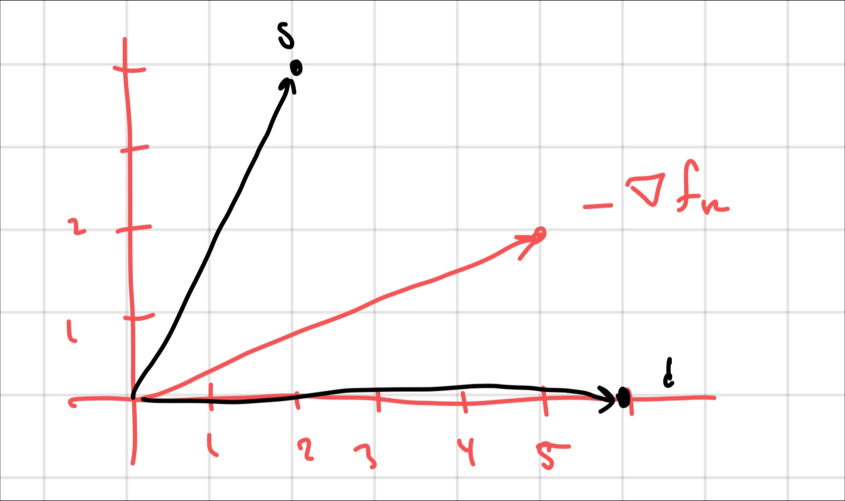

In [4]:
linesearch_file = "linesearch_example.jpg"
linesearch_ex = load(linesearch_file)

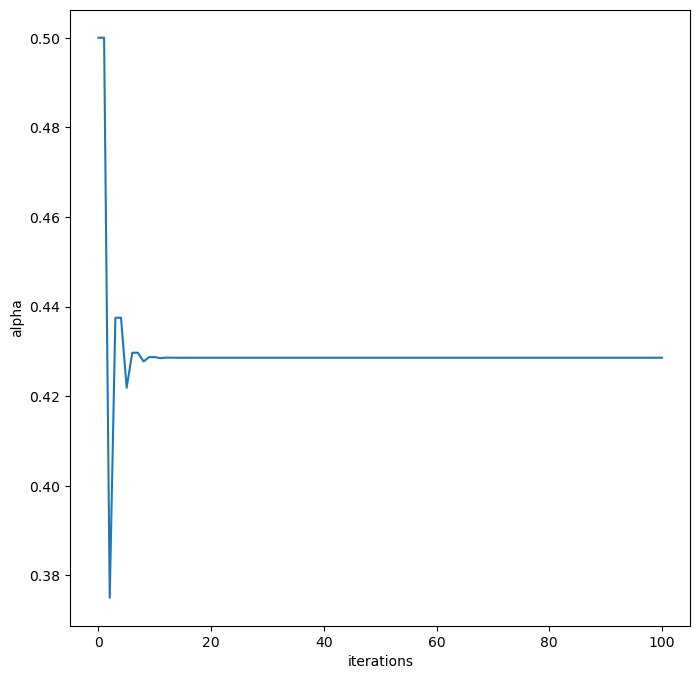

In [5]:
# grad_f = 2 .* (rand(Float16,(5,1)) .- 0.5) 
# s = 2 .* (rand(Float16,(5,1)) .- 0.5)
# d = 2 .* (rand(Float16,(5,1)) .- 0.5)
# print([grad_f,s,d])

grad_f = [-5,-2]
s = [2,4]
d = [6,0]

alpha_mid,alpha_storage = linesearch(grad_f,s,d);

fig = figure(figsize=(8,8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(alpha_storage);
ax1.set_ylabel("alpha");
ax1.set_xlabel("iterations");

## Testing argmin function
The test for the argmin function is the following example.
NOTE: in the figure, what's listed as $\nabla f$ should actually be labelled $-\nabla f$.

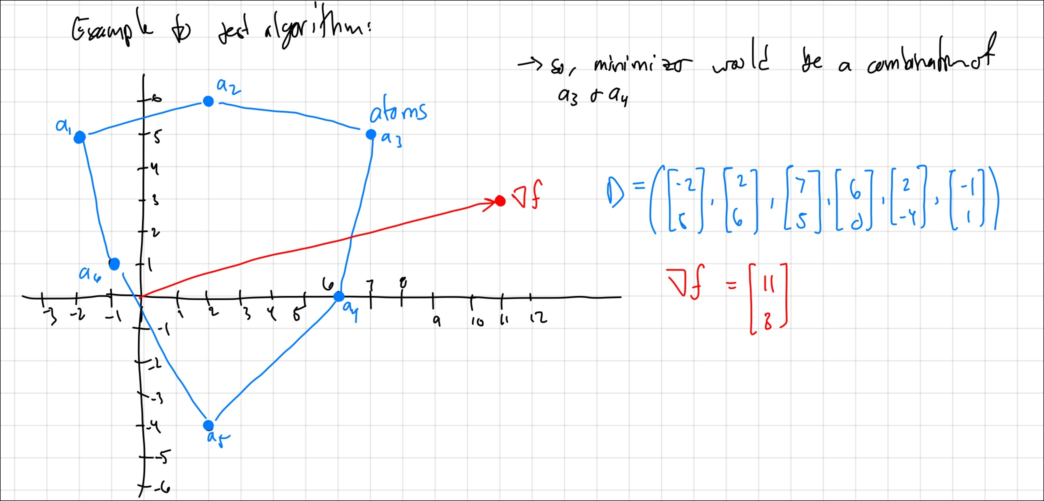

In [6]:
argmin_file = "argmin_example.jpg"
argmin_ex = load(argmin_file)

In [94]:
D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])
grad_f = [-11;-3];

s,max_inds = get_s(D,grad_f)
print("argmin is: ")
println(s)
print("the atoms used are:")
print(max_inds[max_inds .> 0])

argmin is: [6.346153855352895, 1.7307692767644767]
the atoms used are:[4.0, 3.0]

## Testing Frank-Wolfe

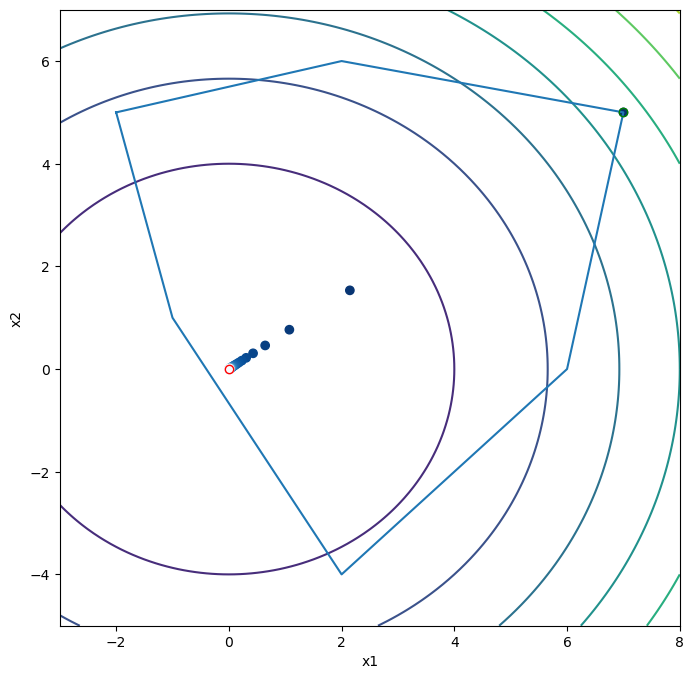

In [21]:
function func(x)
    return (1/2) * sum(x .^ 2)
end

D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])
K = 50
x_history = frank_wolfe(D,func,K) # does this weird thing where it overwrites D? and outputs that?? I don't understand

# Plotting
X,Y = meshgrid(-3:0.1:8,-5:0.1:7)

fig = figure(figsize=(8,8))
D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])

ax1 = fig.add_subplot(1, 1, 1)
ax1.contour(X,Y,reshape([ func(vcat(X[:]',Y[:]')[:,i]) for i in 1:size(X[:])[1] ],size(X)) ) 
ax1.plot(vcat(D[1,:],D[1,1]),vcat(D[2,:],D[2,1]))
ax1.scatter(x_history[1,:],x_history[2,:],c=[1:K+1],cmap="Blues_r")
ax1.plot(x_history[1,1],x_history[2,1],markerfacecolor="none",markeredgecolor="g",linestyle="none",marker="o")
ax1.plot(x_history[1,end],x_history[2,end],markerfacecolor="none",markeredgecolor="r",linestyle="none",marker="o")
ax1.set_ylabel("x2");
ax1.set_xlabel("x1");

In [112]:
D[1,end]

-1

## Actual project
### Prepare Images

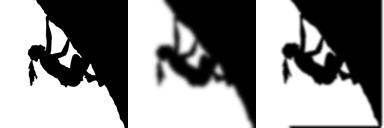

In [284]:
# Clear image
original_path = "smaller_climber128.jpg"
original = load(original_path)
original_grey = Gray.(original)
original_array = convert(Array{Float64}, original_grey)

n, = size(original_array)

# Blurring in photoshop
blurry_path = "smaller_climber_blurry.jpg"
blurry1 = load(blurry_path)
blurry_grey = Gray.(blurry1)
blurry1_array = convert(Array{Float64}, blurry_grey)

# Blurring in Julia
#Kernel = (1/16) .* [1 2 1;2 4 2;1 2 1] # gaussian blur 3x3 from https://en.wikipedia.org/wiki/Kernel_(image_processing)
Kernel = (1/256) .* [1 4 6 4 1; 4 16 24 16 4; 6 24 36 24 6; 4 16 24 16 4; 1 4 6 4 1]
m = size(Kernel)[1]
conv_matrix = ConvolutionMatrix(Kernel,n)
blurry_array = reshape(conv_matrix * original_array[:],size(original_array))


mosaicview(original, blurry1, Gray.(blurry_array); nrow=1)

### Frank-Wolfe Algorithm

In [336]:
function objective(X_wav,R,wav,B)
    X = idwt(X_wav, wav, 3) # commented out since derivative doesn't like the transform to occur in the objective...
    return (1/2) * sum(( (R * X[:]) - B[:]) .^ 2)
end

function obejctive_gradient(X_wav,R,W,B,wav)
    println(size(W[:]' * R' * R))
    println(size(R))
    println(size(idwt(X_wav, wav, 3)[:]))
    return (W[:])' * R' * R * idwt(X_wav, wav, 3)[:] - B' * R * W[:] 
end

wt = wavelet(WT.haar) # define wavelet to use in transform
wt = WT.scale(wt, 1) # 1/sqrt(2) scales output to be between 0 and 1 - useful? idk

K = 30 # frank-wolfe iterations

X0_wav = dwt(blurry_array,wt,3) # make initial condition the wavelet transform of blurry matrix
tau = 1 # make tau the 1-norm of the wavelet transform of blurry matrix
W = idwt(I(n), wt, 3)

f = (y -> objective(y,conv_matrix,wt,blurry_array)) # set objective function
f_grad = (y -> obejctive_gradient(y,conv_matrix,W,blurry_array,wt))
# X_wav_sol = frank_wolfe(tau,f,f_grad,K,X0_wav,wt); # call frank-wolfe
# X_sol = idwt(X_wav_sol, wt, 3); # inverse wavelet transform to bring back to the image domain

In [312]:
f_grad(X0_wav)

(1, 16384)
(16384, 16384)
(16384,)


LoadError: DimensionMismatch("")

### Print Result

In [272]:
X = reshape(X_sol,size(blurry_array))
Gray.(X)

-0.520843505859375

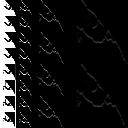

In [315]:
wt = WT.scale(wt,1)
X0_wav = dwt(blurry_array,wt,3)
X0_wav_vec = dwt(blurry_array[:],wt,3)
Gray.(X0_wav)
Gray.(reshape(X0_wav_vec,size(X0_wav)))


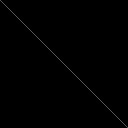

In [333]:
# wt = WT.scale(wt,sqrt(2))
# W = idwt(I(n), wt, 3)
Gray.(W)

In [81]:
#save("3000_gaussian_copy.png", Gray.(X))
# X2 = deepcopy(X)
# X2[X2 .> 1] .= 1
# Gray.(X2)

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\evich\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180


3484

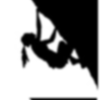

In [39]:
Gray.(reshape(conv_matrix * original_array[:],size(original_array)))

In [31]:
sparse(conv_matrix)

10000×10000 SparseMatrixCSC{Float64,Int64} with 90000 stored entries:
  [1    ,     1]  =  0.0625
  [9799 ,     1]  =  0.0625
  [9800 ,     1]  =  0.125
  [9801 ,     1]  =  0.0625
  [9899 ,     1]  =  0.125
  [9900 ,     1]  =  0.25
  [9901 ,     1]  =  0.125
  [9999 ,     1]  =  0.0625
  [10000,     1]  =  0.125
  [1    ,     2]  =  0.125
  [2    ,     2]  =  0.0625
  [9800 ,     2]  =  0.0625
  ⋮
  [9899 ,  9999]  =  0.125
  [9997 ,  9999]  =  0.0625
  [9998 ,  9999]  =  0.125
  [9999 ,  9999]  =  0.0625
  [9798 , 10000]  =  0.0625
  [9799 , 10000]  =  0.125
  [9800 , 10000]  =  0.0625
  [9898 , 10000]  =  0.125
  [9899 , 10000]  =  0.25
  [9900 , 10000]  =  0.125
  [9998 , 10000]  =  0.0625
  [9999 , 10000]  =  0.125
  [10000, 10000]  =  0.0625

In [91]:
mod(1,10)

1

In [137]:
I_t = dwt(vcat([1],ones(8)),wavelet(WT.haar))
#reshape(I_t,size(I(10)))

9-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [135]:
I_t = idwt(ones(3),wavelet(WT.haar))

3-element Array{Float64,1}:
 2.0
 2.0
 2.0

In [159]:
Kernel = (1/256) .* [1 4 6 4 1; 4 16 24 16 4; 6 24 36 24 6; 4 16 24 16 4; 1 4 6 4 1]
m = size(Kernel)[1]
padding = Int((m-1)/2)

n, = size(original_array)
B = zeros((n+2*padding,n+2*padding))
B[1+padding:end-padding,1+padding:end-padding] = original_array
N = size(B)[1]

# Atoms for 1-norm are standard basis vectors
tau = 6000 #sum(blurry_array)
D = I(n^2)
K = 30
conv_matrix = ConvolutionMatrix(Kernel,n)

blurry_array = reshape(conv_matrix * original_array[:],size(original_array))

128×128 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6875    0.9375
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.3125    0.6

(10000,)

In [219]:
wt = wavelet(WT.haar)
wt = WT.scale(wt, 1/sqrt(2)) # 1/sqrt(2) scales output to be between 0 and 1

bt = dwt(blurry_array[:], wt, 3)# l = 3 is the number of "layers"
ot = dwt(original_array[:], wt, 3)
# dwt!(xt, blurry_array, wt, 3) 

wt = WT.scale(wt, sqrt(2))
x = idwt((1/2 .* bt[:] + (1/2) .* ot[:]), wt, 3)

16384-element Array{Float64,1}:
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 0.35355339059327384
 ⋮
 0.16902166426836016
 0.16485138070897262
 0.16664554261728065
 0.16525905873260116
 0.16679355633415582
 0.16539082459145277
 0.16676819894926168
 0.16538171506458219
 0.16354521368064495
 0.1690803173140139
 0.17311175855626604
 0.18000626631094185

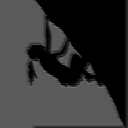

In [220]:
Gray.(reshape(x,size(blurry_array)))

In [210]:
maximum(xt)

1.0

In [229]:
B1 = Ball1(zeros(2), 6.)
Binf = ((1/2) .* ones(2), 0.5)

([0.5, 0.5], 0.5)

6-element SparseVector{Bool,Int64} with 1 stored entry:
  [4]  =  1